<img src='logos/EUMETSAT_Logo_WhiteonBlue.png' alt='logo EUMETSAT' align='right' width='30%'></img>

## <span style="color:blue">**MTG LI data explore**</span>

<hr>

# LI Lightning Group (LGR) and Lightning Flash (LFL) accumulation plotter

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
Notebook requirements:
    
This notebook demonstrates operations on MTG LI products, which can be downloaded by following the instructions provided in the notebook [**1_6_MTG_LI_data_access.ipynb**](https://gitlab.eumetsat.int/eumetlab/data-services/eumdac_data_store/-/blob/master/1_6_MTG_LI_data_access.ipynb?ref_type=heads)
    

</div>
<hr>

### About

This notebook demonstrates how to plot Level 2 LI-LGR (Lightning Groups) or LI-LFL (Lightning Flashes) point data on a gridded (accumulation) map, with colors indicating the the total number of flashes/groups per grid cell across all the input files.

Both group and flash data are delivered with a repeat cycle of 10 seconds. On EUMETSAT data store, data files correspond to 10-minute-long files.

### Module Content:
- [1 - Select dates to be displayed (groups/flashes)](#LI_load)
- [2 - Display flashes/groups on a gridded map](#Data_display)


### Data used

| Product Description   | Data Store collection ID| Product Navigator | 
|:--------------------: |:-----------------------:|:-------------:|
| MTG LI level-2 Flash  | EO:EUM:DAT:0691         | <a href="https://data.eumetsat.int/data/map/EO:EUM:DAT:0691">link</a> |
| MTG LI level-2 Groups | EO:EUM:DAT:0782         | <a href="https://data.eumetsat.int/data/map/EO:EUM:DAT:0691">link</a> |


A product is made of the following files:
* **Body chunks** (NetCDF): One body chunk containing the measured data values in NetCDF structure.
* Trailer chunk (NetCDF): One trailer chunk that contains at least the list of preceding body chunks that have been produced for the dataset. 
* Quicklooks (PNG): Images related to data that enable fast viewing for the purpose of selection by archive users.
* manifest.xml: The manifest contains further information about the SIP, especially the relationships among the different items constituting the package.
* EOPMetadata.xml: The EOPMetadata file contains metadata about the product based on the OGC Earth Observation Metadata Profile of Observations and Measurements (OGC document 10-157r4).

<hr>

##### Load required libraries

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository

In [1]:
from glob import glob
from satpy.scene import Scene
from datetime import datetime
from AuxiliaryFunctions import filter_filenames
from AuxiliaryFunctions import plot_lmap_from_filenames, grid_totals, plot_accmap

/home/jovyan/weather-labs-1/MTGNEW/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## <a id='LI_load'></a>1. Select the dates to be displayed 

From the [EUMETSAT Data Store](https://data.eumetsat.int/data/map/EO:EUM:DAT:MSG:HRSEVIRI), we can download LI data sensed for a specific date. The **Data_folder** variable should point to the folder containing the data, unzipped by the LI data download Notebook. As the data is contained in the **BODY** files, and since the data files have 'BODY' in their filenames, we need to use the wildcard *BODY* to search for the relevant files within the folder. Another wildcard `/*/` is needed as each product is unzipped into its own subdirectory.

In [12]:
Data_folder='downloads/*BODY*.nc'


We save the list with the filenames in the folder into a variable called filenames, and sort the list:

In [13]:
filenames = glob(Data_folder)
filenames.sort()

### <a id='Select_time'></a>1.1 Select Time Range

<div class="alert alert-block alert-success">
<b>Time range is defined in the next cell:</b><br />
</div>

This notebook is prepared to display all LI data available in the input folder (Data_folder/). However, you can customize the display by selecting a specific time range. <br>
**Setting the Time Range:**
1. Define the start time by using the format: <br>
start_dt = datetime (year, month, day, hour, minute).

2. Define the end time by by using the format: <br>
end_dt = datetime (year, month, day, hour, minute). <br><br>

**Example:**<br>
To set the range of times to be displayed between start time September 1, 2024, at 16:30 and 18:30:<br>
start_dt = datetime (2024, 9, 1, 16, 30).<br>
end_dt = datetime (2024, 9, 1, 18, 30).

Note: please be aware that in minute you should choose **0 / 10 /20 /30 /40 /50**

In [14]:
start_dt = datetime(2024, 10, 29, 0, 0)
end_dt = datetime(2024, 10, 30, 0, 0)

In [15]:
filtered_files = filter_filenames(filenames, start_dt, end_dt)


Next, you can use the `Scene` constructor from the [satpy](https://satpy.readthedocs.io/en/stable/index.html) library to load the data files. Once loaded, a `Scene` object represents a single geographic region of data, typically at a single continuous time range.

You have to specify the two keyword arguments `reader` and `filenames` in order to successfully load a scene. 

In [16]:
scn = Scene(reader="li_l2_nc", 
            filenames=filtered_files)

In this JN we demonstrate how to obtain spatial distribution of lightning flashes or groups across parts of the globe with colors indicating the total number of flashes/groups per grid cell across all the input files. Therefore, we will be loading the 'latitude' and 'longitude' datasets.

In [17]:
latitude_dataset_name='latitude'
longitude_dataset_name='longitude'
scn.load([latitude_dataset_name, longitude_dataset_name])
latitude_dataset = scn[latitude_dataset_name].compute()
longitude_dataset = scn[longitude_dataset_name].compute()

/home/jovyan/weather-labs-1/MTGNEW/lib/python3.9/site-packages/pyspectral/config.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


We can also check the total number of lat/lon points to be gridded (they have equal length):

In [18]:
print(f'Total of imported lightning observations: {len(latitude_dataset)}')

Total of imported lightning observations: 2213430


## <a id='Data_display'></a>2. Display flashes/groups on a gridded map

### <a id='Select_region'></a>2.1 Select Region Of Interest

The notebook is set by default to display lightning data over the entire area covered by the Lightning Imager.
However, if you would like to focus on a specific Area Of Interest (AOI), you can do so by entering the latitude and longitude coordinates in the variable provided. So:
* If you prefer to use the default area, leave the 'line area_nswe = None' uncommented.
* If you want to select your own AOI, uncomment the line for the AOI and enter your specific coordinates. The format should be **[lat_max, lat_min, lon_min, lon_max]**

In [46]:
#area_nswe = None
area_nswe = [45, 30, -10, 10] # Spain
#area_nswe = [65, 30, -10, 30]

Another important parameter for accumulation maps is the grid cell size. The default 1.0 means that total numbers of LFLs/LGRs are computed and plotted in 1.0x1.0 degree grid. This is quite good for global view. To reveal finer details of storms in regional scale, one can use 0.5, 0.25 or 0.2 degree grid cells. 

Keep in mind that smaller grid cells mean less observations per grid cell, and therefore the colour scale maximum below might need to be set to a lower value. 

In [47]:
reso = .1

And here we can adjust the colour scale maximum accumulation, that will appear red on the map. The default 5000 works well with 24 hours of data, using 1.0 degree grid cell size. Smaller grid cell size and/or shorter time period generally requires lower scale maximum for using the whole colour range while longer time period can require higher scale maximum. 

In [48]:
col_scale_max = 5000

Optionally we can also plot the boundaries of the field-of-views of the 4 LI cameras by setting the `plot_fov` below `True`. Please consider that especially if the data is not corrected for the parallax effect, a few LI lightning locations can also appear slightly outside the outer boundaries of the field-of-view polygons. 

In [49]:
plot_fov = True

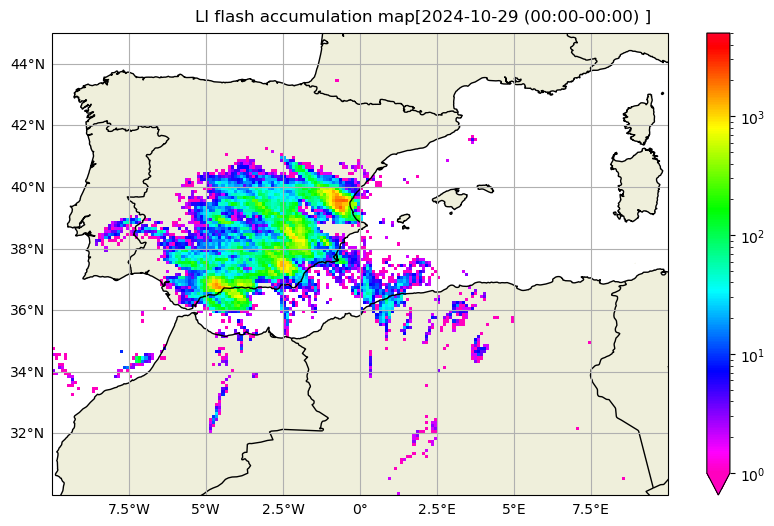

In [50]:
title = f'LI flash accumulation map''[' + start_dt.strftime("%Y-%m-%d") + ' (' + start_dt.strftime("%H:%M") + '-' + end_dt.strftime("%H:%M")+ ') '+ ']'
li_grid = grid_totals(latitude_dataset, longitude_dataset, area=None, reso=reso)
plot_accmap(li_grid, area=area_nswe, title=title, vmax=col_scale_max, plot_fov=plot_fov)

<div style="border: 1px solid #ccc; padding: 10px; background-color: transparent;">

Please try to analyze the obtained map, keeping the following questions in mind as part of your interpretation: 

Which regions on the map show the highest concentration of lightning flashes?

What additional details can be seen, compared to plotting just time-coloured lightning locations?

How does the lightning amounts over land and over the seas/oceans compare? What can be the physical mechanism between the differences. 

What could explain the relatively lower concentration of lightning flashes at higher latitudes compared to the equatorial regions in this dataset?

Choose an area with high lightning activity and explore it in more detail, by limiting the spatial extent of the plot, increasing the grid resolution and adjusting the colour scale accordingly. 